In [66]:
from os import listdir
import xarray
import cftime
import numpy as np
import matplotlib.pyplot as plt
import xarray
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats import linregress
from scipy.stats import norm
from matplotlib import rc
import regionmask
import cartopy.crs as ccrs
from matplotlib import rc


def sig_testing(all_ds, xaer_ds):
    all_array = all_ds.values
    xaer_array = xaer_ds.values

    def welch_t_test(all_pt, xaer_pt, lat, lon):
        t_val, p_val = ttest_ind(all_pt, xaer_pt, equal_var=False)
        return ((lat, lon), p_val)

    results = []
    for lati, lat in enumerate(all_ds.lat.values):
        for loni, lon in enumerate(all_ds.lon.values):
            all_pt = all_array[0:all_ds["member"].size, 0:all_ds["year"].size, lati, loni].flatten()
            xaer_pt = xaer_array[0:xaer_ds["member"].size, 0:xaer_ds["year"].size, lati, loni].flatten()
            t_value, p_value = ttest_ind(all_pt, xaer_pt, equal_var=False)
            results.append(((lat, lon), p_value))

    sig_results = (all_ds.mean(dim="member").mean(dim="year").load() * 0).rename("p-value")
    for (lat, lon), p_value in results:
        sig_results.loc[dict(lat=lat, lon=lon)] = p_value
    return sig_results

In [36]:
HEAD_DIR = "/projects/dgs/persad_research/heat_research/data/"

TREFHTMN_ALL = HEAD_DIR + "OUTPUT/METRICS/TREFHTMN/ALL/"
all_hwf_fut = xarray.open_mfdataset([TREFHTMN_ALL + name for name in listdir(TREFHTMN_ALL) if "20060101-20801231" in name], combine="nested", concat_dim="member")["HWF"].load()
all_hwf_hist = xarray.open_mfdataset([TREFHTMN_ALL + name for name in listdir(TREFHTMN_ALL) if "19200101-20051231" in name], combine="nested", concat_dim="member")["HWF"].load()
all_hwf_full = xarray.concat([all_hwf_hist, all_hwf_fut], dim="year")

TREFHTMN_XAER = HEAD_DIR + "OUTPUT/METRICS/TREFHTMN/XAER/"
xaer_hwf_fut = xarray.open_mfdataset([TREFHTMN_XAER + name for name in listdir(TREFHTMN_XAER) if "20060101-20801231" in name], combine="nested", concat_dim="member")["HWF"].load()
xaer_hwf_hist = xarray.open_mfdataset([TREFHTMN_XAER + name for name in listdir(TREFHTMN_XAER) if "19200101-20051231" in name], combine="nested", concat_dim="member")["HWF"].load()
xaer_hwf_full = xarray.concat([xaer_hwf_hist, xaer_hwf_fut], dim="year")

landfrac = xarray.open_dataset(HEAD_DIR + "LANDFRAC/DOWNLOAD/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.040001-049912.nc")["LANDFRAC"].mean(dim="time")

coslat = np.cos(np.deg2rad(all_hwf_full.lat))
lat_weight = coslat / coslat.mean(dim='lat')

all_hwf_spatial = all_hwf_full.where(landfrac > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon").sel(year=slice(1930,2080)).load()
all_hwf_spatial_mavg = all_hwf_spatial.mean(dim="member")

xaer_hwf_spatial = xaer_hwf_full.where(landfrac > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon").sel(year=slice(1930,2080)).load()
xaer_hwf_spatial_mavg = xaer_hwf_spatial.mean(dim="member")

In [50]:
def get_rolling_slopes(timeseries: xarray.DataArray, window=30) -> xarray.DataArray:
    min_window = int(np.floor(window/2))
    max_window = int(np.ceil(window/2))
    
    slopes = np.zeros(timeseries.values.shape[0] - min_window - max_window)
    pvalues = np.zeros(slopes.size)
    times = np.zeros(slopes.size)
    
    for center_index in range(min_window, timeseries.values.shape[0] - max_window):
        window = timeseries[center_index - min_window:center_index + max_window]
        slope, intercept, r, p, se = linregress(np.arange(window.size), window)
        times[center_index - min_window] = timeseries.year.values[center_index]
        slopes[center_index - min_window] = slope
        pvalues[center_index - min_window] = p
        
    return (xarray.DataArray(
        slopes,
        coords=[times],
        dims="time",
    ), xarray.DataArray(
        pvalues,
        coords=[times],
        dims="time",
    ))
    
xaer_slopes, xaer_pvals = get_rolling_slopes(xaer_hwf_spatial.mean(dim="member"))
all_slopes, all_pvals = get_rolling_slopes(all_hwf_spatial.mean(dim="member"))

Text(0, 0.5, 'Slope (Δ HWF/Year)')

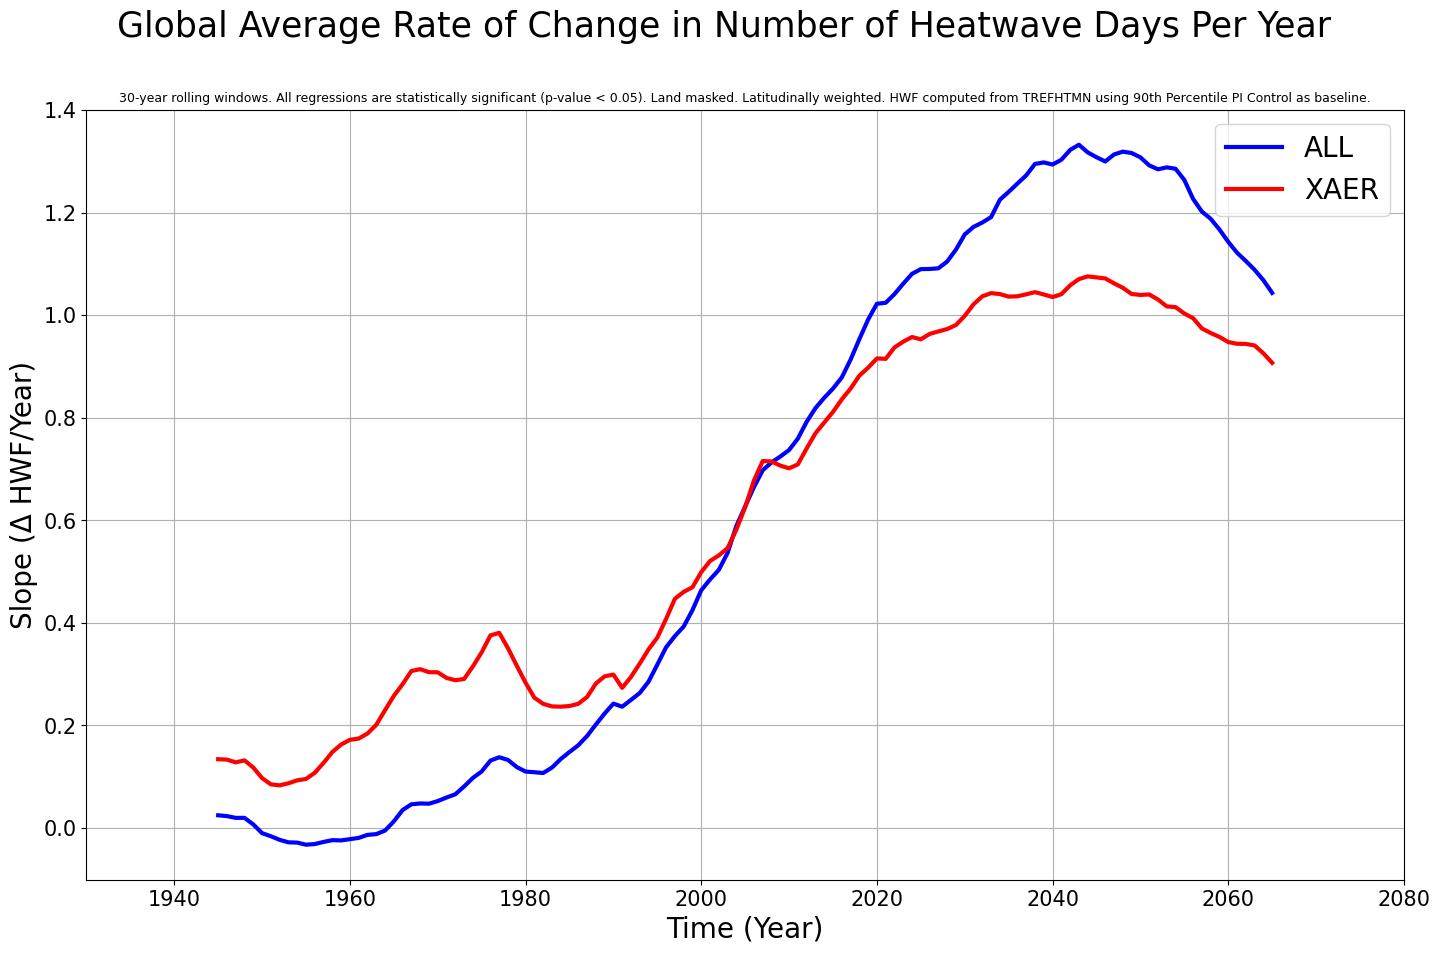

In [64]:
rc('font', **{'size': 15})
f, ax1 = plt.subplots(1, 1, figsize=(17, 10), facecolor='w')
f.suptitle("Global Average Rate of Change in Number of Heatwave Days Per Year", fontsize=25)

lw = 3

all_slopes.plot(ax=ax1, color="Blue", label="ALL", linewidth=lw)
xaer_slopes.plot(ax=ax1, color="Red", label="XAER", linewidth=lw)

fz = 20
ax1.set_title("30-year rolling windows. All regressions are statistically significant (p-value < 0.05). Land masked. Latitudinally weighted. HWF computed from TREFHTMN using 90th Percentile PI Control as baseline.", fontsize=9)
ax1.grid()
ax1.legend(fontsize=fz)
ax1.set_xlim(1930, 2080)
ax1.set_xlabel("Time (Year)", fontsize=fz)
ax1.set_ylabel("Slope (Δ HWF/Year)", fontsize=fz)

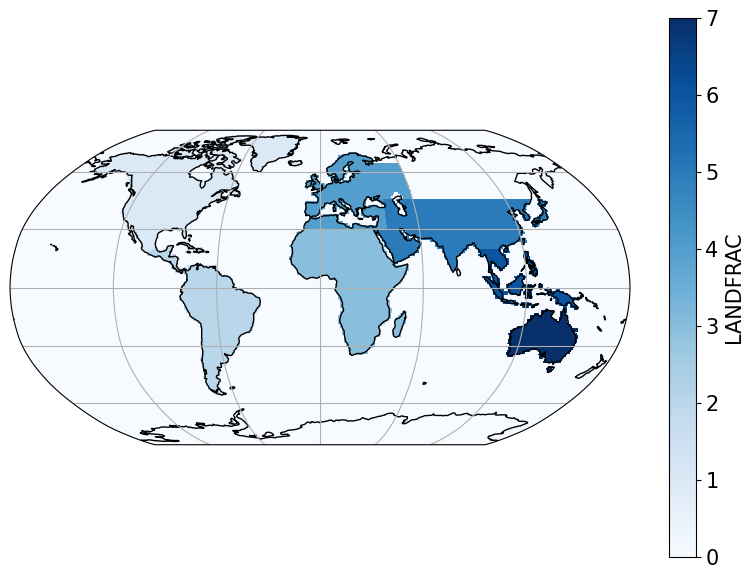

In [67]:
landfrac = xarray.open_dataset(HEAD_DIR + "LANDFRAC/DOWNLOAD/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.040001-049912.nc")["LANDFRAC"].mean(dim="time")

ar6_mask = regionmask.defined_regions.ar6.land.mask(landfrac.lon, landfrac.lat)

graphic = landfrac.copy()*0
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 6).fillna(0).values > 0)*1
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).fillna(0).values > 0)*2
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).fillna(0).values > 0)*3
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).fillna(0).values > 0)*4
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).fillna(0).values > 0)*5
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask == 38).fillna(0).values > 0)*6
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).fillna(0).values > 0)*7

proj = ccrs.Robinson()
f, ax1 = plt.subplots(1, 1, figsize=(10, 7), facecolor='w', subplot_kw=dict(projection=proj))

graphic.plot(ax=ax1, transform=ccrs.PlateCarree(), linewidths=1, cmap="Blues")

ax1.coastlines()
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

In [69]:
all_na = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 6).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_csa = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_af = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_euro = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_sa = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_oc = all_hwf_full.where(landfrac > 0).where(ar6_mask == 38).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_au = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")

xaer_na = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 6).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_csa = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_af = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_euro = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_sa = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_oc = xaer_hwf_full.where(landfrac > 0).where(ar6_mask == 38).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_au = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")

all_na_slopes, all_na_pvals = get_rolling_slopes(all_na)
all_csa_slopes, all_csa_pvals = get_rolling_slopes(all_csa)
all_af_slopes, all_af_pvals = get_rolling_slopes(all_af)
all_euro_slopes, all_euro_pvals = get_rolling_slopes(all_euro)
all_sa_slopes, all_sa_pvals = get_rolling_slopes(all_sa)
all_oc_slopes, all_oc_pvals = get_rolling_slopes(all_oc)
all_au_slopes, all_au_pvals = get_rolling_slopes(all_au)

xaer_na_slopes, xaer_na_pvals = get_rolling_slopes(xaer_na)
xaer_csa_slopes, xaer_csa_pvals = get_rolling_slopes(xaer_csa)
xaer_af_slopes, xaer_af_pvals = get_rolling_slopes(xaer_af)
xaer_euro_slopes, xaer_euro_pvals = get_rolling_slopes(xaer_euro)
xaer_sa_slopes, xaer_sa_pvals = get_rolling_slopes(xaer_sa)
xaer_oc_slopes, xaer_oc_pvals = get_rolling_slopes(xaer_oc)
xaer_au_slopes, xaer_au_pvals = get_rolling_slopes(xaer_au)

Text(0.2, 0.92, '30-year rolling windows. All regressions are statistically significant (p-value < 0.05). Land masked. Latitudinally weighted. HWF computed from TREFHTMN using 90th Percentile PI Control as baseline.')

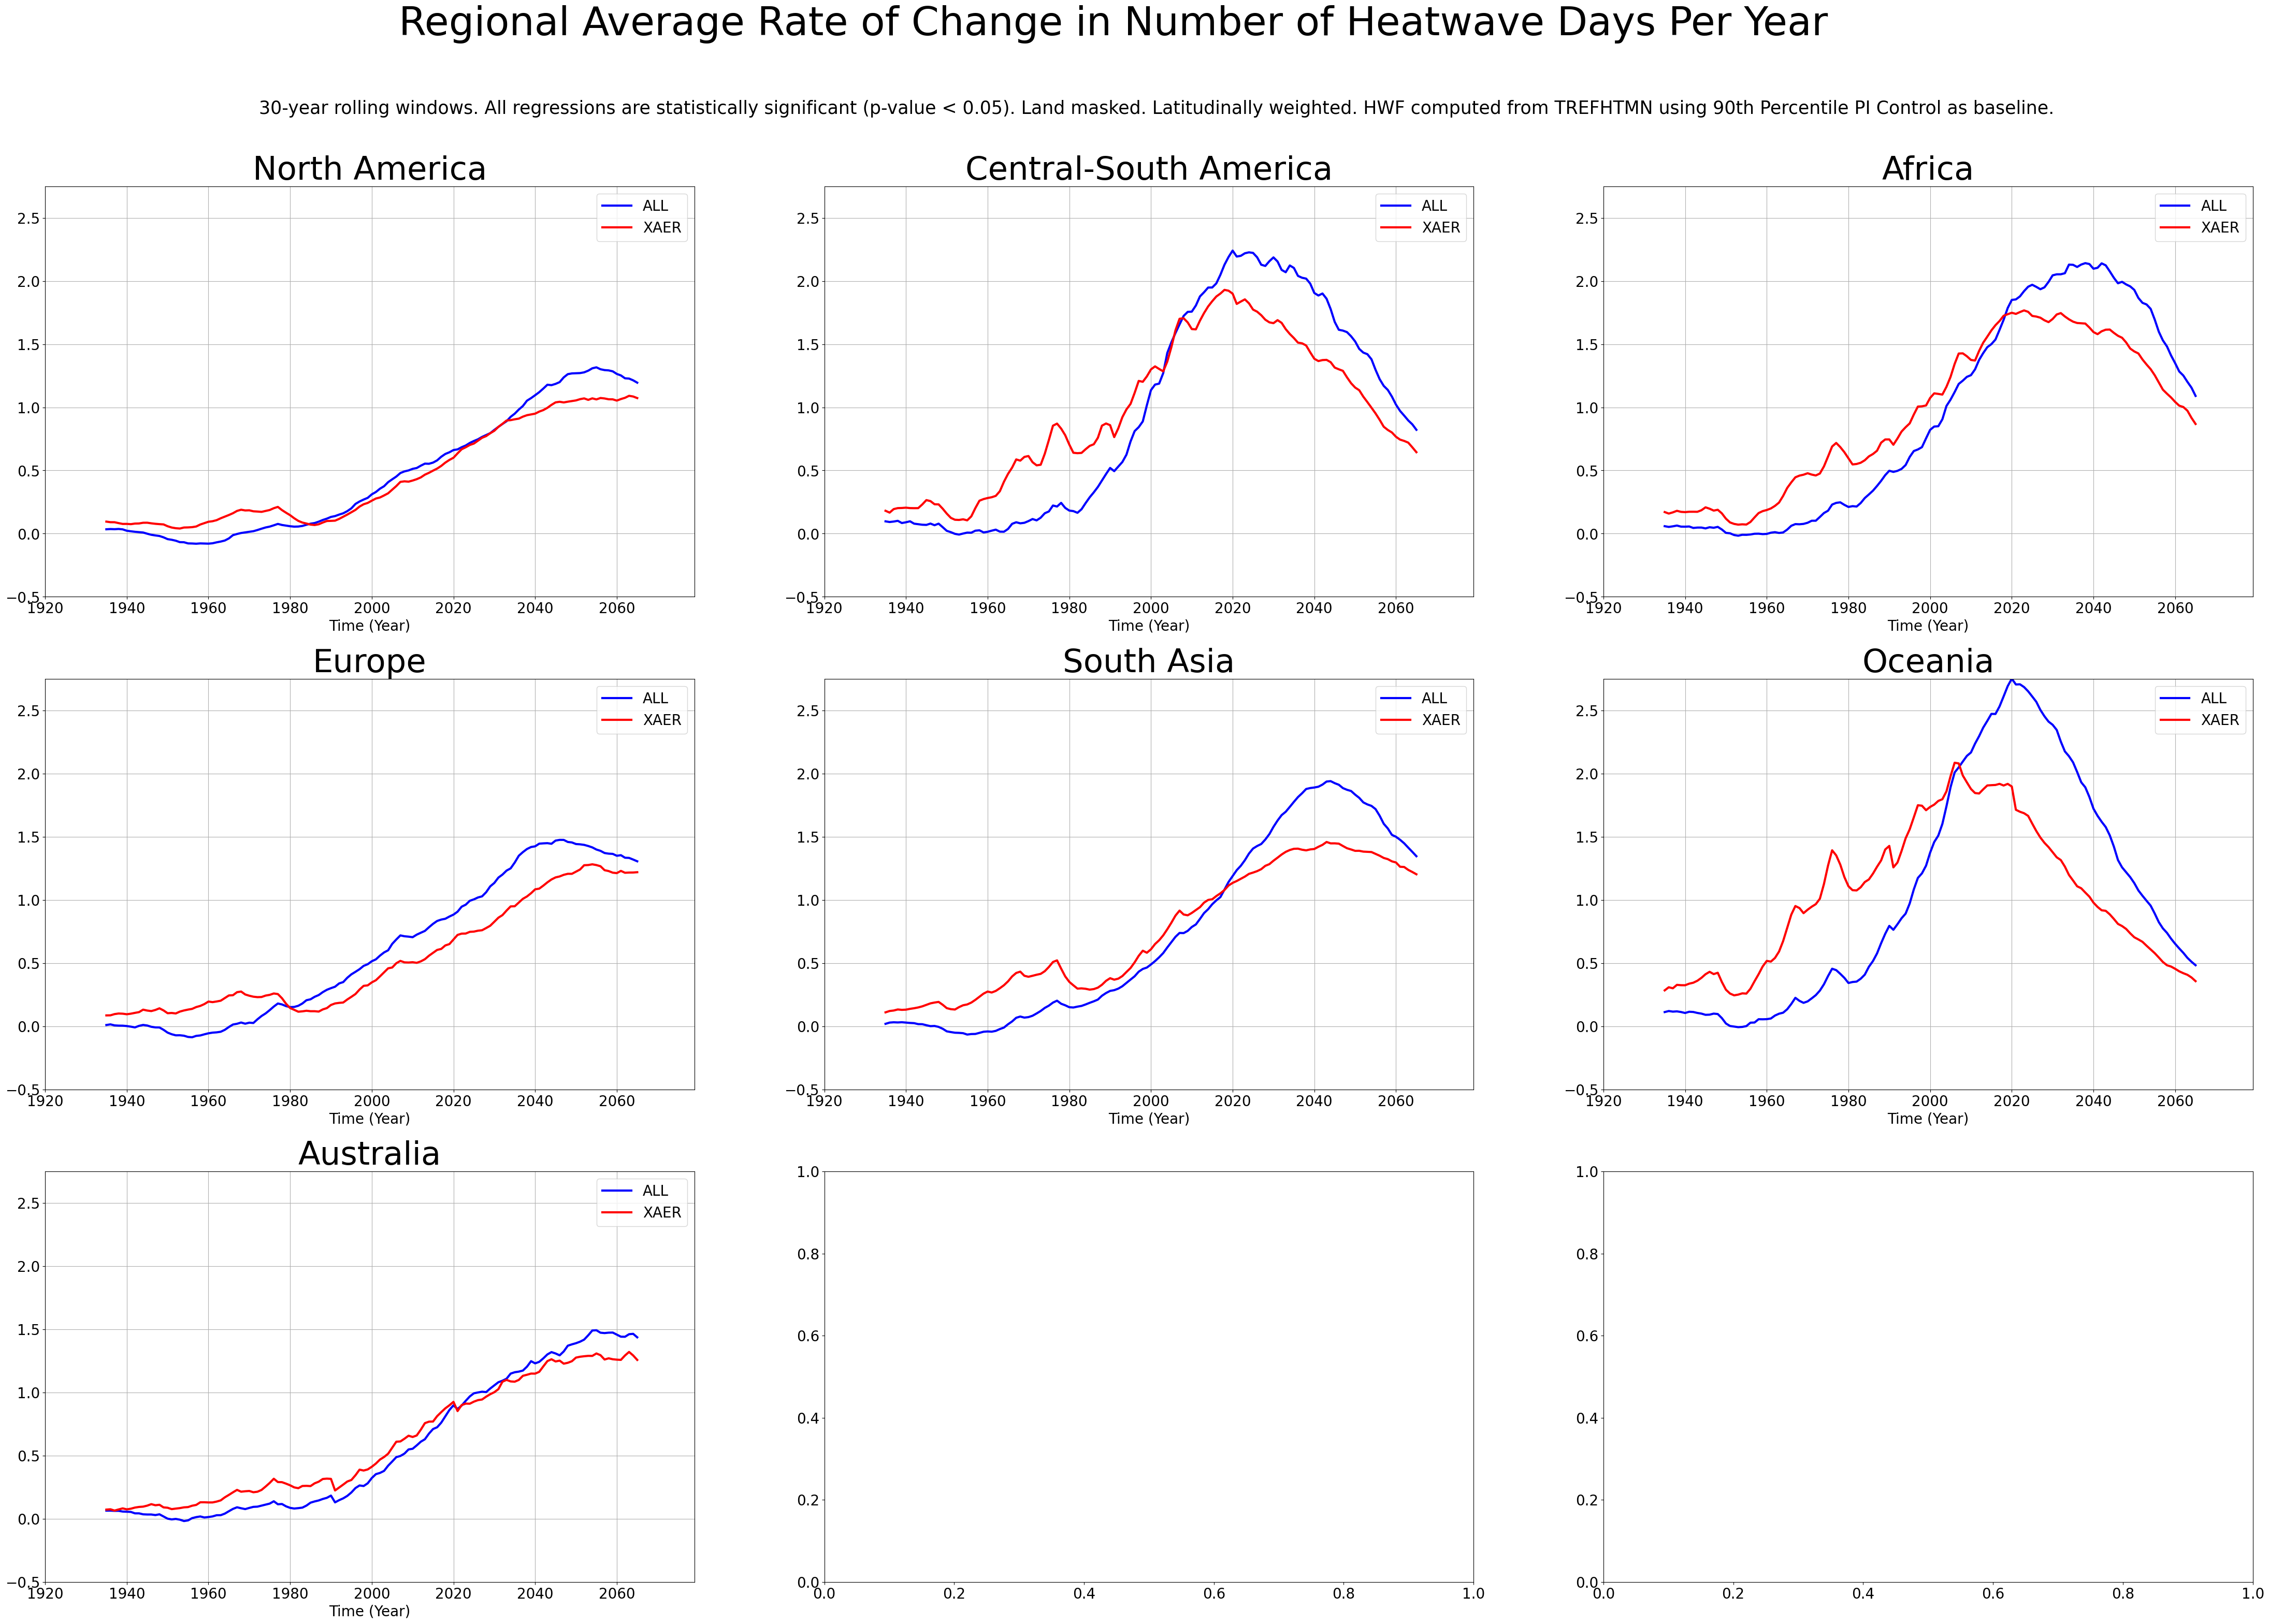

In [88]:
rc('font', **{'size': 20})
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(55, 35), facecolor='w')
f.suptitle("Regional Average Rate of Change in Number of Heatwave Days Per Year", fontsize=55)


lw = 3


all_na_slopes.plot(ax=ax1, color="Blue", linewidth=lw, label="ALL")
all_csa_slopes.plot(ax=ax2, color="Blue", linewidth=lw, label="ALL")
all_af_slopes.plot(ax=ax3, color="Blue", linewidth=lw, label="ALL")
all_euro_slopes.plot(ax=ax4, color="Blue", linewidth=lw, label="ALL")
all_sa_slopes.plot(ax=ax5, color="Blue", linewidth=lw, label="ALL")
all_oc_slopes.plot(ax=ax6, color="Blue", linewidth=lw, label="ALL")
all_au_slopes.plot(ax=ax7, color="Blue", linewidth=lw, label="ALL")

xaer_na_slopes.plot(ax=ax1, color="Red", linewidth=lw, label="XAER")
xaer_csa_slopes.plot(ax=ax2, color="Red", linewidth=lw, label="XAER")
xaer_af_slopes.plot(ax=ax3, color="Red", linewidth=lw, label="XAER")
xaer_euro_slopes.plot(ax=ax4, color="Red", linewidth=lw, label="XAER")
xaer_sa_slopes.plot(ax=ax5, color="Red", linewidth=lw, label="XAER")
xaer_oc_slopes.plot(ax=ax6, color="Red", linewidth=lw, label="XAER")
xaer_au_slopes.plot(ax=ax7, color="Red", linewidth=lw, label="XAER")

fz = 45

ax1.set_title("North America", fontsize=fz)
ax2.set_title("Central-South America", fontsize=fz)
ax3.set_title("Africa", fontsize=fz)
ax4.set_title("Europe", fontsize=fz)
ax5.set_title("South Asia", fontsize=fz)
ax6.set_title("Oceania", fontsize=fz)
ax7.set_title("Australia", fontsize=fz)

yu = 2.75
yl = -0.5

ax1.grid()
ax1.set_xlim(1920,2079)
ax1.set_ylim(yl, yu)
ax1.set_xlabel('Time (Year)')
ax1.legend()
ax2.grid()
ax2.set_xlim(1920,2079)
ax2.set_ylim(yl, yu)
ax2.set_xlabel('Time (Year)')
ax2.legend()
ax3.grid()
ax3.set_xlim(1920,2079)
ax3.set_ylim(yl, yu)
ax3.set_xlabel('Time (Year)')
ax3.legend()
ax4.grid()
ax4.set_xlim(1920,2079)
ax4.set_ylim(yl, yu)
ax4.set_xlabel('Time (Year)')
ax4.legend()
ax5.grid()
ax5.set_xlim(1920,2079)
ax5.set_ylim(yl, yu)
ax5.set_xlabel('Time (Year)')
ax5.legend()
ax6.grid()
ax6.set_xlim(1920,2079)
ax6.set_ylim(yl, yu)
ax6.set_xlabel('Time (Year)')
ax6.legend()
ax7.grid()
ax7.set_xlim(1920,2079)
ax7.set_ylim(yl, yu)
ax7.set_xlabel('Time (Year)')
ax7.legend()

f.text(0.2,0.92,"30-year rolling windows. All regressions are statistically significant (p-value < 0.05). Land masked. Latitudinally weighted. HWF computed from TREFHTMN using 90th Percentile PI Control as baseline.", fontsize=25)
